# Monet style transfer with CycleGAN

## Introduction

For this project we will be participating in a Kaggle competition [I'm Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/overview).

The goal is to build a GAN that generates images in the style of Monet.

Submissions are evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).

The smaller MiFID is, the better the generated images are.

To achive this, we will build a Cycle-Consistent Adversarial Network, also known as CycleGAN, that to perform unpaired image to image translation, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593). This method can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples.

CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain.

GitHub repository for this project can be found at: https://github.com/nabilahforuni/gans

## Loading data and EDA

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import time
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-12 11:50:35.818273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 11:50:35.818372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 11:50:35.958821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
PATH = '/kaggle/input/gan-getting-started'
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
monet_ds = keras.utils.image_dataset_from_directory(
    PATH + '/monet_jpg',
    labels=None,
    label_mode=None,
    batch_size=None,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 300 files.


In [4]:
photo_ds = keras.utils.image_dataset_from_directory(
    PATH + '/photo_jpg',
    labels=None,
    label_mode=None,
    batch_size=None,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 7038 files.


We have 300 images of Monet paitings and 7038 photos to which we will be transfering Monet's style. Let's take sample painting and sample photo for later use.

In [5]:
sample_monet = next(iter(monet_ds))
sample_photo = next(iter(photo_ds))

Take a look at some of the paintings.

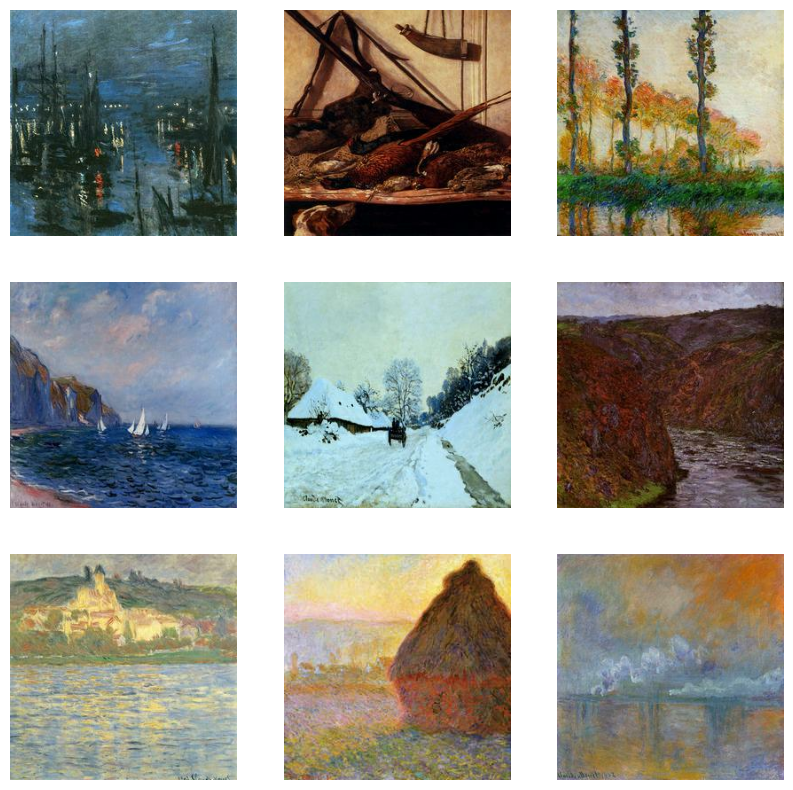

In [6]:
plt.figure(figsize=(10, 10))
images = iter(monet_ds.take(9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = next(images)
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")

And some photos.

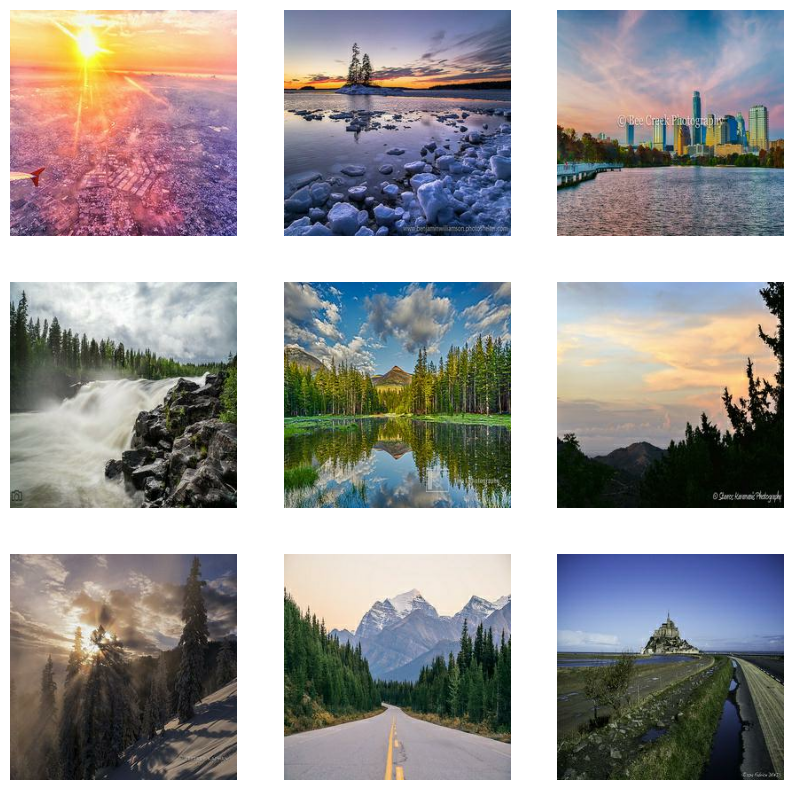

In [7]:
plt.figure(figsize=(10, 10))
images = iter(photo_ds.take(9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = next(images)
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis("off")

## Data Preprocessing

As mentioned in the paper, we need to apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

+ In random jittering, the image is resized to 286 x 286 and then randomly cropped to 256 x 256.

+ In random mirroring, the image is randomly flipped horizontally i.e., left to right.

In [8]:
def random_crop(image):
    cropped_image = tf.image.random_crop(
        image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

In [9]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [10]:
def random_jitter(image):
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image = random_crop(image)

    image = tf.image.random_flip_left_right(image)

    return image

In [11]:
def preprocess_image_train(image):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [12]:
def preprocess_image_test(image):
    image = normalize(image)
    return image

In [13]:
monet_ds = monet_ds.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

photo_ds = photo_ds.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

## Building the CycleGAN

In [14]:
OUTPUT_CHANNELS = 3

Cyclegan uses [instance normalization](https://arxiv.org/abs/1607.08022) instead of [batch normalization](https://arxiv.org/abs/1502.03167).

In [15]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

The generator of we will use is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler).

+ Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU

+ Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU

+ There are skip connections between the encoder and decoder (as in the U-Net).

In [16]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=False))

    if apply_norm:
        if norm_type.lower() == 'batchnorm':
            result.add(tf.keras.layers.BatchNormalization())
        elif norm_type.lower() == 'instancenorm':
            result.add(InstanceNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [17]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [18]:
def generator(output_channels, norm_type='batchnorm'):
    down_stack = [
        downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
        downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
        downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
        downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
        downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
        downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
        downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
        downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
        upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
        upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
        upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 4, strides=2,
        padding='same', kernel_initializer=initializer,
        activation='tanh')  # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    x = inputs

  # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

The discriminator is a convolutional PatchGAN classifier — it tries to classify if each image patch is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

+ Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.

+ The shape of the output after the last layer is (batch_size, 30, 30, 1).
Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image.

+ The discriminator receives 2 inputs:

    + The input image and the target image, which it should classify as real.


    + The input image and the generated image (the output of the generator), which it should classify as fake.
    
    + Use tf.concat([inp, tar], axis=-1) to concatenate these 2 inputs together.

In [19]:
def discriminator(norm_type='batchnorm', target=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    x = inp

    if target:
        tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
        x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer,
        use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    if norm_type.lower() == 'batchnorm':
        norm1 = tf.keras.layers.BatchNormalization()(conv)
    elif norm_type.lower() == 'instancenorm':
        norm1 = InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    if target:
        return tf.keras.Model(inputs=[inp, tar], outputs=last)
    else:
        return tf.keras.Model(inputs=inp, outputs=last)

CycleGAN consists of 2 generators and 2 discriminators:

+ First generator learns to transform photo to a Monet painting

+ Second generator learns to transfom Monet painting to a photo

+ First discriminator learns to differentiate between real Monet painting and a generated one

+ Second discriminator lerns to differentiate between real photo and a generated one

In [20]:
generator_monet = generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_photo = generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_monet = discriminator(norm_type='instancenorm', target=False)
discriminator_photo = discriminator(norm_type='instancenorm', target=False)

In [21]:
sample_monet = next(iter(monet_ds.take(1)))
sample_photo = next(iter(photo_ds.take(1)))

Let's see what untrained generators do.

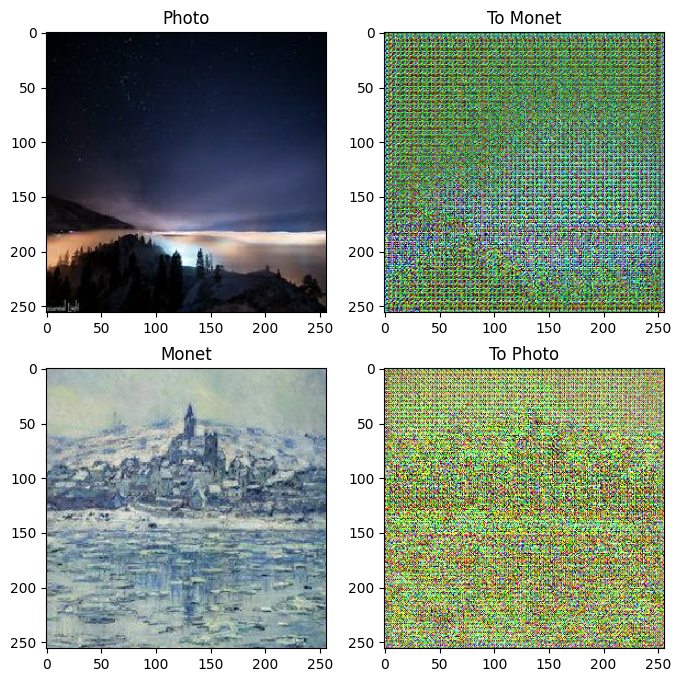

In [22]:
to_monet = generator_monet(sample_photo)
to_photo = generator_photo(sample_monet)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_photo, to_monet, sample_monet, to_photo]
title = ['Photo', 'To Monet', 'Monet', 'To Photo']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

And what untrained discriminators do.

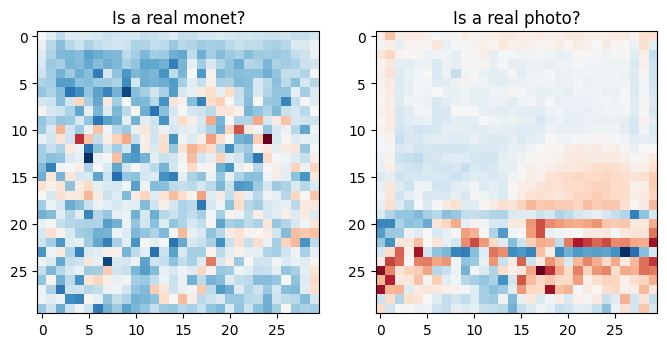

In [23]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real monet?')
plt.imshow(discriminator_monet(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real photo?')
plt.imshow(discriminator_photo(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input and the target pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.


In [24]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

+ The discriminator_loss function takes 2 inputs: real images and generated images.

+ real_loss is a sigmoid cross-entropy loss of the real images and an array of ones (since these are the real images).

+ generated_loss is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).

+ The total_loss is the sum of real_loss and generated_loss.

In [25]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

### Generator loss

+ The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.

In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

### Cycle consistency

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the original sentence.

In cycle consistency loss,

+ Photo is passed via generator_monet that yields generated Monet painting

+ Generated Monet painting is passed via generator_photo that yields cycled photo 

+ Mean absolute error is calculated between real photo and cycled one

In [26]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [27]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [28]:
generator_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Definne a checkpoint-saver

In [29]:
checkpoint_path = "/kaggle/working"

ckpt = tf.train.Checkpoint(generator_monet=generator_monet,
                           generator_photo=generator_photo,
                           discriminator_monet=discriminator_monet,
                           discriminator_photo=discriminator_photo,
                           generator_monet_optimizer=generator_monet_optimizer,
                           generator_photo_optimizer=generator_photo_optimizer,
                           discriminator_monet_optimizer=discriminator_monet_optimizer,
                           discriminator_photo_optimizer=discriminator_photo_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

## Training

Define a helper-function to generate and display images.

In [30]:
EPOCHS = 50

def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

Define a training loop that consists of four steps:

+ Get the predictions

+ Calculate the loss

+ Calculate the gradients using backpropagation

+ Apply the gradients to the optimizer

In [31]:
@tf.function
def train_step(real_monet, real_photo):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_monet = generator_monet(real_monet, training=True)
        cycled_photo = generator_photo(fake_monet, training=True)

        fake_photo = generator_photo(real_monet, training=True)
        cycled_monet = generator_monet(fake_photo, training=True)

        # same_x and same_y are used for identity loss.
        same_photo = generator_photo(real_photo, training=True)
        same_monet = generator_monet(real_monet, training=True)

        disc_real_photo = discriminator_photo(real_photo, training=True)
        disc_real_monet = discriminator_monet(real_monet, training=True)

        disc_fake_photo = discriminator_photo(fake_photo, training=True)
        disc_fake_monet = discriminator_monet(fake_monet, training=True)

        # calculate the loss
        gen_monet_loss = generator_loss(disc_fake_monet)
        gen_photo_loss = generator_loss(disc_fake_photo)

        total_cycle_loss = calc_cycle_loss(real_photo, cycled_photo) + calc_cycle_loss(real_monet, cycled_monet)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_monet_loss = gen_monet_loss + total_cycle_loss + identity_loss(real_monet, same_monet)
        total_gen_photo_loss = gen_photo_loss + total_cycle_loss + identity_loss(real_photo, same_photo)

        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)

    # Calculate the gradients for generator and discriminator
    generator_monet_gradients = tape.gradient(total_gen_monet_loss, 
                                        generator_monet.trainable_variables)
    generator_photo_gradients = tape.gradient(total_gen_photo_loss, 
                                        generator_photo.trainable_variables)

    discriminator_photo_gradients = tape.gradient(disc_photo_loss, 
                                            discriminator_photo.trainable_variables)
    discriminator_monet_gradients = tape.gradient(disc_monet_loss, 
                                            discriminator_monet.trainable_variables)

    # Apply the gradients to the optimizer
    generator_monet_optimizer.apply_gradients(zip(generator_monet_gradients, 
                                            generator_monet.trainable_variables))

    generator_photo_optimizer.apply_gradients(zip(generator_photo_gradients, 
                                            generator_photo.trainable_variables))

    discriminator_photo_optimizer.apply_gradients(zip(discriminator_photo_gradients,
                                                discriminator_photo.trainable_variables))

    discriminator_monet_optimizer.apply_gradients(zip(discriminator_monet_gradients,
                                                discriminator_monet.trainable_variables))

Run the training loop.

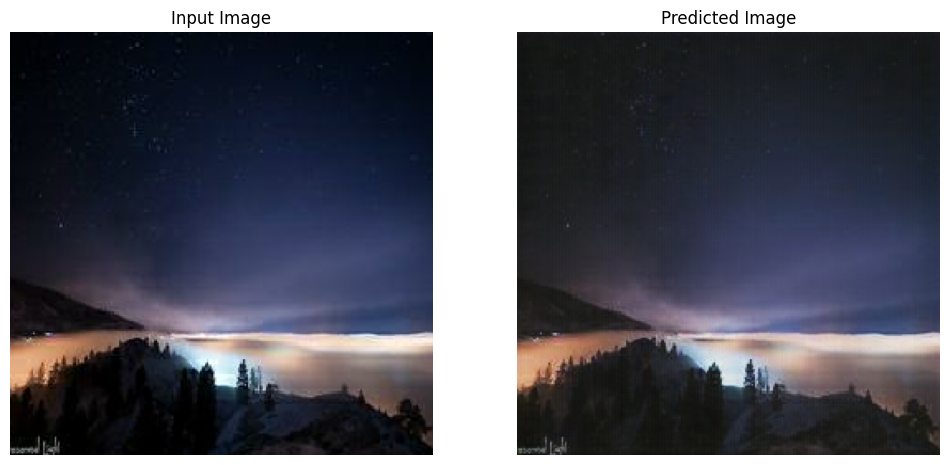

Saving checkpoint for epoch 100 at /kaggle/working/ckpt-20
Time taken for epoch 100 is 79.03965997695923 sec



In [32]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_photo, image_monet in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(image_photo, image_monet)
        if n % 10 == 0:
            print ('.', end='')
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_monet, sample_photo)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

Generate some images to look at the results.

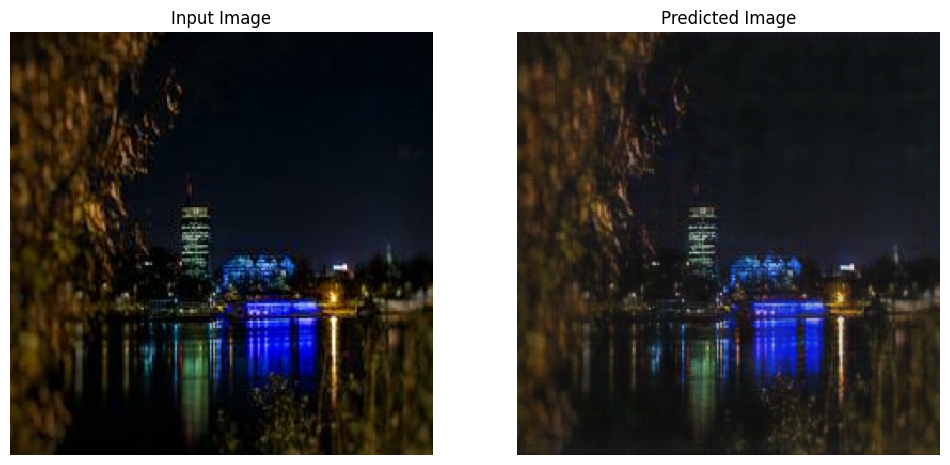

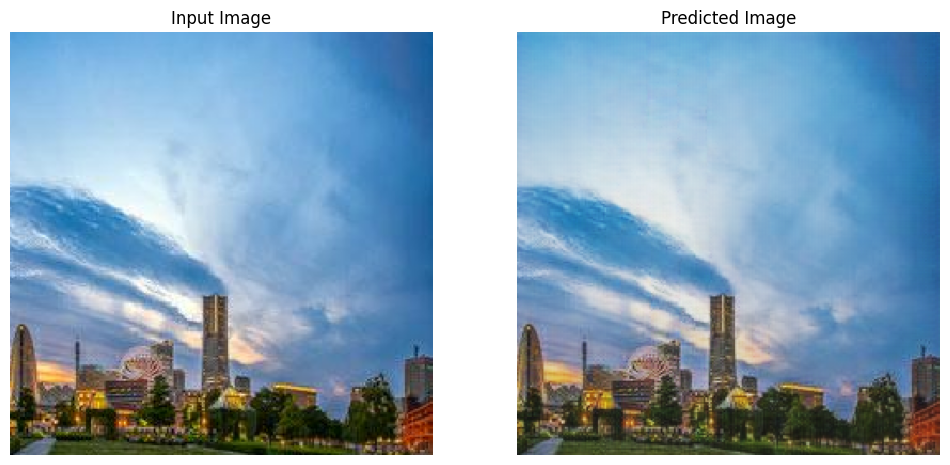

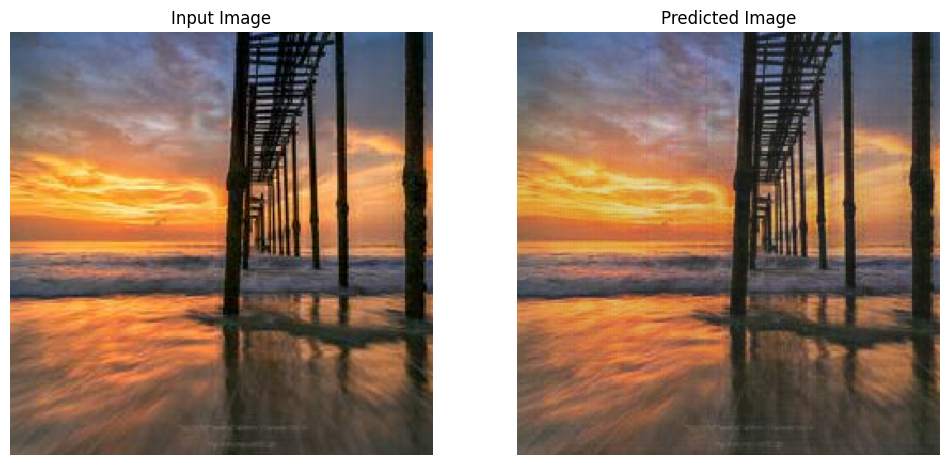

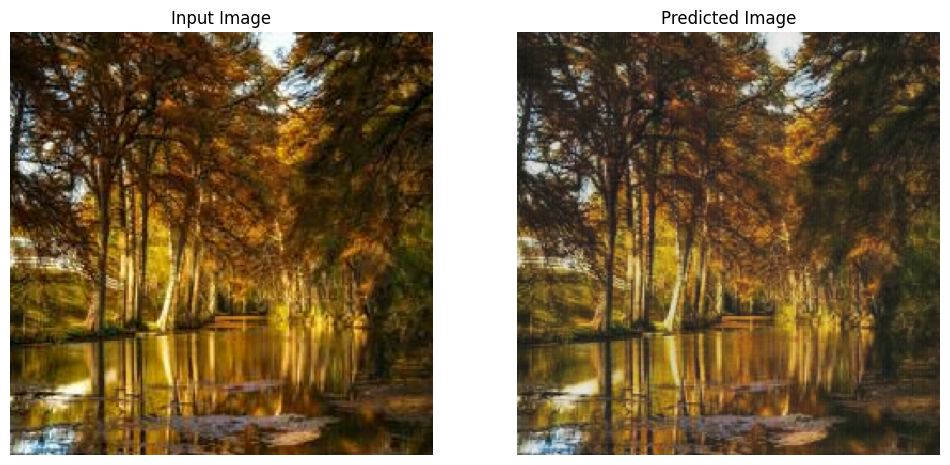

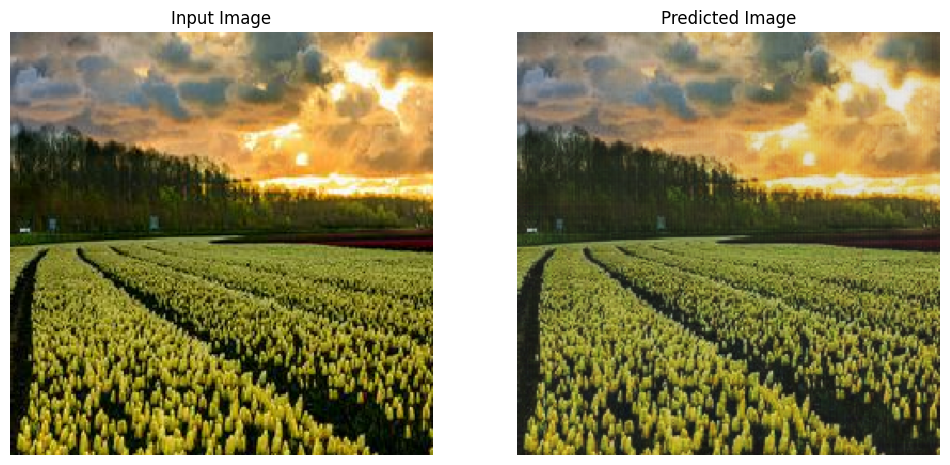

In [33]:
for photo in photo_ds.take(5):
    generate_images(generator_monet, photo)

## Creating a submission file

In [34]:
import PIL
! mkdir ../tmp

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Load the photo dataset again and this time preprocess it without the random jitter.

In [ ]:
photo_ds = keras.utils.image_dataset_from_directory(
    PATH + '/photo_jpg',
    labels=None,
    label_mode=None,
    batch_size=None,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

photo_ds = photo_ds.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

Generate the Monet-stylized images.

In [35]:
i = 1
for photo in photo_ds:
    prediction = generator_monet(photo, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = PIL.Image.fromarray(prediction)
    img.save(f"../tmp/{i}.jpg")
    i += 1

Create a zip archive to submit to the competition.

In [36]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/tmp")

'/kaggle/working/images.zip'

This submission received score of 74.97846 which puts us at 54th position on the leaderboard. 

## Conclusion

In this project we implemented a Cycle-Consistent Adversatial Networs to perform a style transfer from Monet paintings to photos. 

At a glance, results don't look particularly good but that partially to the Monet's specific style that is arguably very subtle and hence hard to capture. 

The MiFID metric used in the competition, however, suggests that our model does a good job of modifying images to resemble Monet's paintings.

## References

[1] Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks https://arxiv.org/abs/1703.10593

[2] Image-to-Image Translation with Conditional Adversarial Networks https://arxiv.org/abs/1611.07004

[3] https://www.tensorflow.org/tutorials/generative/cyclegan

[4] https://www.tensorflow.org/tutorials/generative/pix2pix

[5] https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py